# Fast Multi-Document RAG using Qdrant Binary Quantization and SambaNova-DeepSeek R1 using LangGraph

When building Retrieval-Augmented Generation (RAG) systems, speed and efficiency are paramount. However, making RAG systems truly fast and scalable, especially with large datasets and high-dimensional embeddings, remains a challenge. What if you could build a RAG system that delivers rapid responses while being incredibly memory efficient? That’s exactly what we’re going to explore by combining the usage of SambaNova Systems’ performant DeepSeek-R1, Qdrant’s Binary Quantization, and the orchestration capabilities of LangGraph.


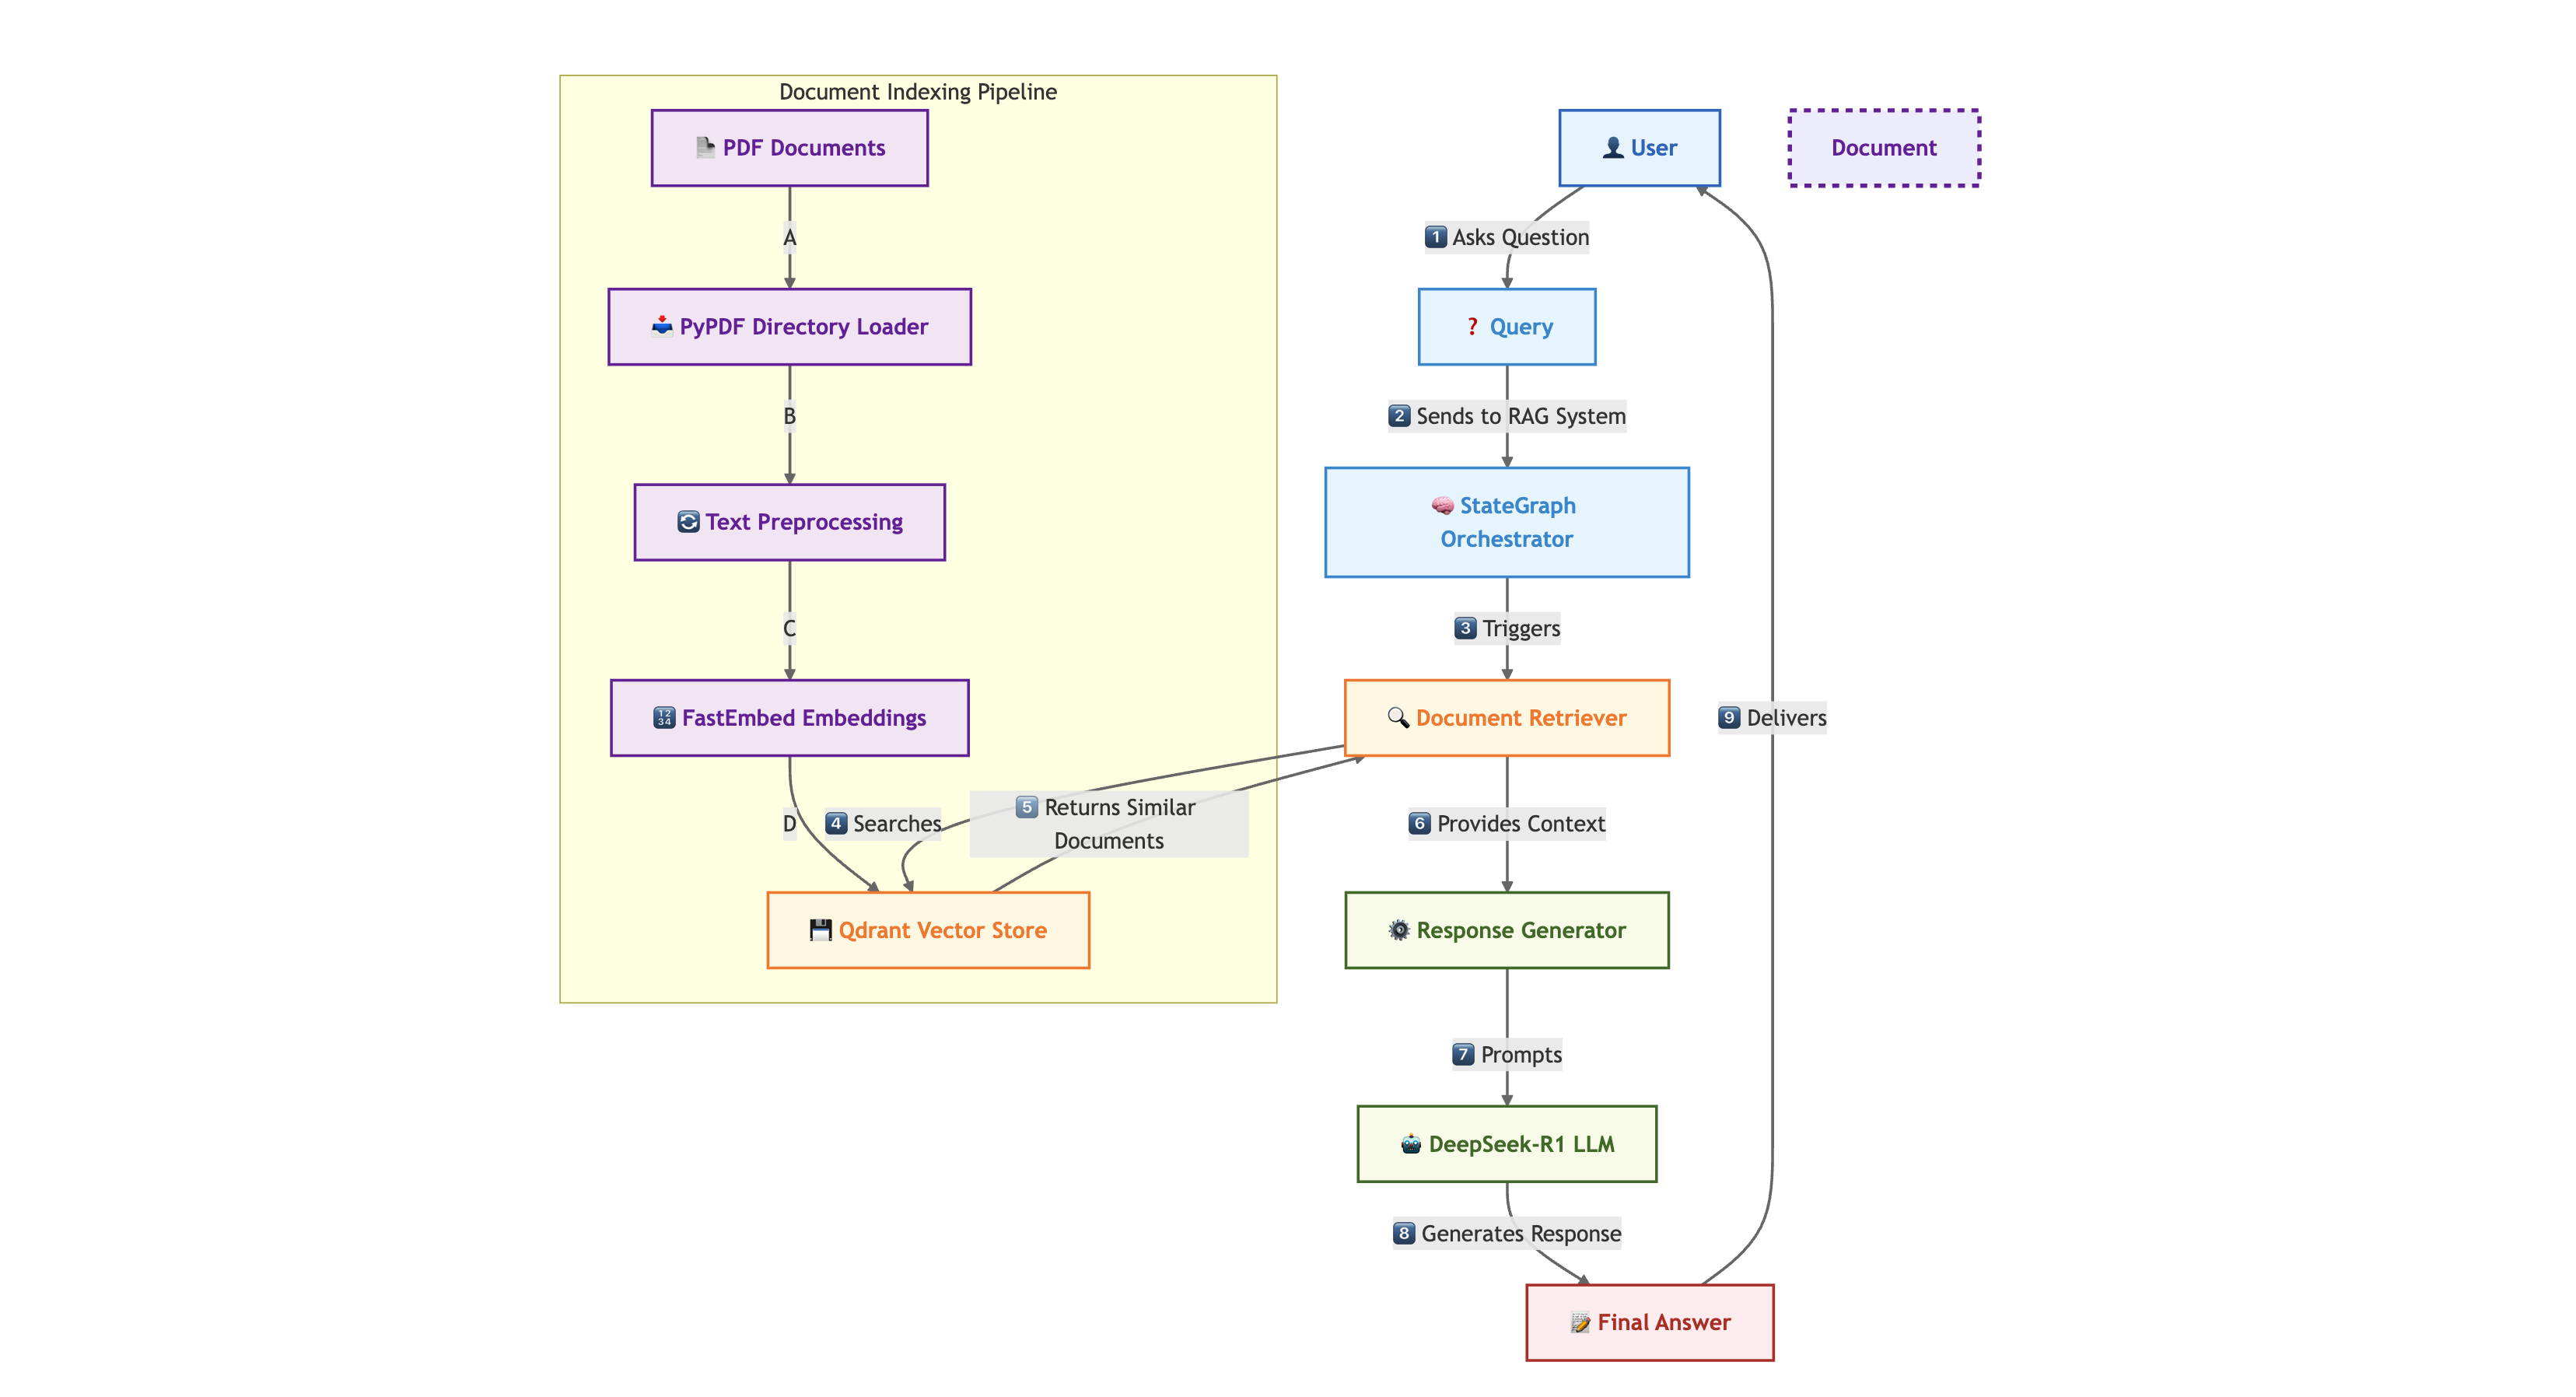

## Installation

In [ ]:
!pip install langchain langchain-community
!pip install langchain-qdrant fastembed
!pip install langchain-sambanova
!pip install langgraph
!pip install pypdf

> Let's import all the necessary libraries.


- LangGraph: For building the Retrieval Augmented Generation pipeline
- FastEmbed: For the lightweight embeddings conversation
- Qdrant: Index the document into the Vector database and use it as retriever
- SambaNova: Faster LLM Inference using DeepSeek R1

In [ ]:
import os
from google.colab import userdata

from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import FastEmbedEmbeddings

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client import models,http

from langchain_sambanova import ChatSambaNovaCloud
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

## Setup Sambanova API Key

We set the environment variable for the SambaNova API key, fetching it securely using userdata.get (common in Colab environments). Then, we initialize the ChatSambaNovaCloud LLM, specifying the model (DeepSeek-R1), maximum tokens for the response, and low temperature and top_p values to make the output more focused and deterministic, which is often desired in RAG applications.

> Get your API keys: https://cloud.sambanova.ai/apis

In [ ]:
os.environ['SAMBANOVA_API_KEY'] = userdata.get("SAMBANOVA_API_KEY")

llm = ChatSambaNovaCloud(
    model="DeepSeek-R1",
    max_tokens=1024,
    temperature=0.1,
    top_p=0.01,
)

## Load your data

Save multiple PDF files inside data directory.

In [ ]:
loader = PyPDFDirectoryLoader(
    path = "./data/",
    glob = "**/[!.]*.pdf",
    extract_images = False,
    mode = "page",
    extraction_mode = "plain",
)

In [ ]:
docs = loader.load()

In [ ]:
for data_content in docs:
    data_content.page_content = data_content.page_content.replace("\n", " ")
    data_content.page_content = data_content.page_content.replace("\t", " ")

## Define the Vector store- Qdrant

- `vectors_config`: Defines the main vector parameters. `size=1024` matches the embedding model we'll use. `distance=models.Distance.COSINE` specifies the similarity metric. `on_disk=True` tells Qdrant to store the full original vectors on disk instead of RAM, saving significant memory.
- `quantization_config`: This is where Binary Quantization is enabled. `models.BinaryQuantization` activates the feature. binary=models.BinaryQuantizationConfig(`always_ram=True`) Instructs Qdrant to keep the binary quantized vectors and their associated index in RAM for fastest access during the initial search phase.

In [ ]:
client = QdrantClient(
    url = userdata.get("qdrant_url"),
    api_key = userdata.get("qdrant_key"),
)

In [ ]:
collection_name = "multi-document-rag"
if not client.collection_exists(collection_name=collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=1024,
                                           distance=models.Distance.COSINE,on_disk=True),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True,
            ),
        ),
    )
else:
    print("Collection already exists")

## Index your document - FastEmbed Embedding and Qdrant Vector store

We initialize the FastEmbedEmbeddings model from Qdrant. thenlper/gte-large is specified, which produces 1024-dimensional vectors, matching the size configuration in the Qdrant collection. Qdrant handles the Binary Quantization and on-disk/in-RAM placement automatically as per the collection configuration.

> Note: This might take some time to save the data


In [ ]:
embeddings = FastEmbedEmbeddings(model_name="thenlper/gte-large")

In [ ]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)

In [ ]:
vector_store.add_documents(docs)

## Augment- Prompt Template

SYSTEM_TEMPLATE sets the persona and desired output format, including the <think> block. HUMAN_TEMPLATE structures the input provided to the LLM, including the retrieved context ``({context_str})`` and the user's question ``({query})``. It also provides instructions on how to handle out-of-context questions and asks the LLM to include source metadata.

In [ ]:
SYSTEM_TEMPLATE = """
You are an expert QA Assistant who answers questions using only the provided context as your source of information. Follow these guidelines:

1. Base your answers exclusively on the information available in the context provided.
2. If the answer cannot be found in the context, clearly state "I don't have enough information in the context to answer this question."
3. Do not use prior knowledge or make assumptions beyond what is explicitly stated in the context.
4. For each answer, include relevant metadata from the context (such as source, page number, or other identifying information).
5. Present answers clearly and concisely, directly addressing the user's question.

Always structure your response in this format:
<think>
[Your step-by-step thinking process here]
</think>

[Your final answer here]
"""

HUMAN_TEMPLATE = """
We have provided context information below.
CONTEXT: {context_str}
---------------------
Given this information, please answer the question: {query}
---------------------
If the question is not from the provided context, say `I don't know. Not enough information received.`

Also include the Metadata i.e., the Source and page number which is added in the context
"""

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k":4})

In [ ]:
user_query = "how to get into the flow?"
retriever.invoke(user_query)

## Define RAG pipeline using LangGraph - State

In [ ]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [ ]:
def search(state: State):
    retrieved_docs = vector_store.max_marginal_relevance_search(state["question"])
    return {"context": retrieved_docs}

In [ ]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content+f"Metadata: Source-{doc.metadata['source']}+ Page: {doc.metadata['page_label']} + ID: {doc.metadata['_id']}" for doc in state["context"])
    messages = [
        {"role": "system", "content": SYSTEM_TEMPLATE},
        {"role": "user", "content": HUMAN_TEMPLATE.format(context_str=docs_content, query=state["question"])},
    ]
    response = llm.invoke(messages)
    return {"answer": response.content}

In [ ]:
def extract_after_think(input_text):
    import re
    match = re.search(r'</think>(.*)', input_text, re.DOTALL)
    return match.group(1).strip() if match else "No </think> tag found in the input"

In [ ]:
graph_builder = StateGraph(State).add_sequence([search, generate])
graph_builder.add_edge(START, "search")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question": user_query})

In [ ]:
print(extract_after_think(response["answer"]))

To enter the flow state, follow these evidence-based strategies from the provided sources:  

1. **Align Challenges with Skills**: Choose tasks that are slightly beyond your current abilities but achievable with effort. This balance prevents boredom (from overly simple tasks) and frustration (from overly difficult ones). *[Source: Ikigai, p. 41]*  
2. **Clarity of Goals and Feedback**: Know what to do, how to do it, and track your progress. For example, the stock-trading exercise in *Rich Dad Poor Dad* provided clear goals (turn $3k into $6k) and real-time feedback (gains/losses). *[Source: Ikigai, p. 41; Rich-Dad-Poor-Dad, p. 159]*  
3. **Eliminate Distractions**: Create an environment free from interruptions to maintain focus. *[Source: Ikigai, p. 41]*  
4. **Train Your "Flow Muscle"**: Regularly engage in activities that require deep concentration to strengthen your ability to enter flow. *[Source: Ikigai, p. 57]*  
5. **Add Novelty**: Introduce new elements to familiar tasks (e.g.,

In [ ]:
response1 = graph.invoke({"question": "how to balance the asset and liabilities?"})

In [ ]:
print(extract_after_think(response1["answer"]))

To balance assets and liabilities effectively, follow these principles from the provided sources:

1. **Acquire Income-Generating Assets**  
   Focus on building assets that put money in your pocket without requiring active work (e.g., rental properties, stocks, royalties). Prioritize investments where you can recover your initial capital quickly (e.g., the condominium example with a 3-year ROI).  
   *Metadata: Source-data/Rich-Dad-Poor-Dad-eBook.pdf, Pages 47, 74, 157*

2. **Minimize Liabilities**  
   Avoid expenses and debts that drain resources (e.g., unnecessary credit purchases, lifestyle inflation). Reduce financial fragility by paying off debt and avoiding obligations that limit freedom.  
   *Metadata: Source-data/Rich-Dad-Poor-Dad-eBook.pdf, Page 74*

3. **Adopt an Antifragile Mindset**  
   Eliminate fragile elements like toxic relationships, unproductive habits, or high-risk ventures. Focus on "good riddance" goals (e.g., reducing debt, limiting social media time) to build